In [1]:
# Load libraries
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# KNN

When using a k-nearest neighbors, KNN, regression model, the prediction assigned to a point is the average target value among the k closest points according to some kind of similarity distance.

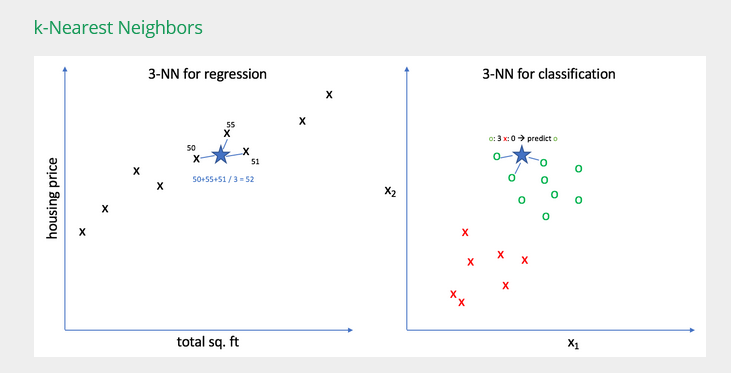

- If k = 1, then each sample is simply assigned the target value of the closest instance.


- If k = 3, each sample will be assigned the mean of the 3 closest points target value.


- ...

## Load Data

AS this is a regression problem, we cannot use iris (😥). We will be using the California Housing dataset instead.

In [2]:
from sklearn.datasets import fetch_california_housing as load_data;

In [ ]:
dat = load_data();
X = pd.DataFrame(dat.data)
X.columns = dat.feature_names
y = dat.target
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [6]:
dat = load_data()
X = pd.DataFrame(dat.data)
dat.target

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

## Train/Val/Test Split

In [ ]:
perc_values = [0.6, 0.2, 0.2];
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size = perc_values[1] + perc_values[2],
                                                          random_state=0);
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size = 0.5)

In [ ]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

### Imports (Steps 1 & 2)

In [ ]:
# 1) Import model
from sklearn.neighbors import KNeighborsRegressor as model_constructor

In [ ]:
# 2) Import metric
from sklearn.metrics import mean_absolute_percentage_error as metric


## Grid Search (Steps 3-6)

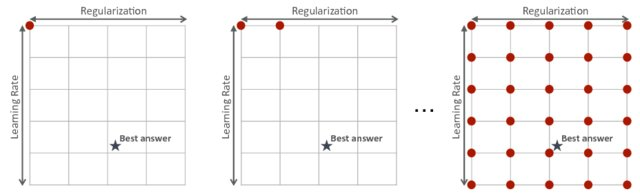

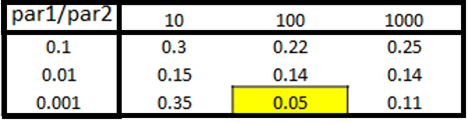

Let's define the grid we will be using.

In [ ]:
params_grid = {'C': [1, 2, 3]}

### Using a Fixed Validation Set

We will use timeit to measure the computational time for each grid search iteration

In [ ]:
from timeit import default_timer
?default_timer

In [ ]:
num_iter = 1;
grid_results = pd.DataFrame(columns = ('k', 'mae_train', 'mae_val', 'time'))
for k in params_grid['C']:

            # Start time
            start_time = default_timer()

            # Print trace
            print('Iteracion = ' + str(num_iter) + '. Parametro k = ' + str(k))

            # [3] Define model
            model = model_constructor(C = k)

            # [4] Train model
            model.fit(X_train, y_train)

            # [5] Predict
            pred_train = model.predict(X_train)
            pred_val = model.predict(X_val)

            # [6] Compute metric
            metric_train = metric(y_train, pred_train)
            metric_val = metric(y_val, pred_val)

            # Computational time
            time = default_timer() - start_time

            # print error
            print('MAE train = %.2f - MAE validation = %.2f. Time spend = %.2f.'
                  % (metric_train, metric_val, time))

            # Save iteration results
            grid_results.loc[num_iter]=[k,
                                     metric_train,
                                     metric_val,
                                    time]
            num_iter += 1

print('Grid Search Total Computational Time: ', np.sum(grid_results.time.values))

Iteracion = 1. Parametro k = 1
MAE train = 0.52 - MAE validation = 0.52. Time spend = 20.14.
Iteracion = 2. Parametro k = 2
MAE train = 0.51 - MAE validation = 0.51. Time spend = 20.96.
Iteracion = 3. Parametro k = 3
MAE train = 0.51 - MAE validation = 0.51. Time spend = 26.59.
Grid Search Total Computational Time:  67.69031781599995


Check results

In [ ]:
grid_results

**Which one is the winner?** Remember to sort in increasing order now!!!

In [ ]:
grid_results = grid_results.sort_values(by = ['mae_val', 'time', 'mae_train'],
                                        ascending = [True, True, True])
grid_results

,k,mae_train,mae_val,time
3,3.0,0.508990,0.508777,26.590905
2,2.0,0.513892,0.513615,20.955694
1,1.0,0.518411,0.517911,20.143718


In [ ]:
best_model = grid_results.iloc[0]
best_model

### Using Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV
?GridSearchCV

In [ ]:
# Define grid
grid_cv = GridSearchCV(model_constructor(),
                     param_grid=params_grid,
                     n_jobs=2, ## Paralellization!
                     cv = 5)

In this case, we do not need a fixed validation set, so we will combine train validation.

In [ ]:
# Run grid
start_time = default_timer()

grid_cv.fit(np.concatenate((X_train, X_val), axis = 0),
            np.concatenate((y_train, y_val), axis = 0))

stop_time = default_timer()
print('CV Grid Search Total Computational Time: : ', stop_time - start_time)

In [ ]:
print('Values validated for k hyperparameter: ' + str(grid_cv.cv_results_['param_n_neighbors']))
print('Validation accuracy: ' + str(grid_cv.cv_results_['mean_test_score']))

## Final Model

Validation has served its purpose, let's combine it with train to get more training data.

In [ ]:
print('Old train data size = ' + str(X_train.shape))
print('Old train target size = ' + str(y_train.shape))

# Combine train and validación
X_train = np.concatenate((X_train, X_val), axis = 0)
y_train = np.concatenate((y_train, y_val), axis = 0)

print('New train data size = ' + str(X_train.shape))
print('New train target size = ' + str(y_train.shape))

Let's use in this case the best hyperparameters from fixed validation set grid search.

In [ ]:
# [3] Define model
model = model_constructor(n_neighbors = int(best_model.k)) # We could also select grid_cv.best_params_['n_neighbors']

# [4] Train model
model.fit(X_train, y_train)

# [5] Predict
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# [6] Compute metric
metric_train = metric(y_train, pred_train)
metric_test = metric(y_test, pred_test)



In [ ]:
# print error
print('MAE train = %.2f - MAE test = %.2f'
      % (metric_train, metric_test))